# Encoder Decoder GPT - 

Week 6 of MLX

In [41]:
# Install dependencies
!pip install torch torchvision
!pip install opencv-python
!pip install pip install pandas datasets requests
!pip install matplotlib
!pip install sentencepiece

  Using cached sentencepiece-0.2.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (7.7 kB)
Using cached sentencepiece-0.2.0-cp312-cp312-macosx_11_0_arm64.whl (1.2 MB)


In [41]:
# Import dependencies

import os

from PIL import Image

import torch
import torch.nn as nn
from torch.nn import functional as F

from datasets import load_dataset
import pandas as pd
import requests
import cv2
import numpy as np

import matplotlib.pyplot as plt

import sentencepiece as spm

import math

In [42]:
# Configuration

using_sentence_piece = True


# Sentence piece config
num_entries_for_sentence_piece_model = 12000
sentencepiece_output_dir = '../sentencepiece_models'
sentencepiece_corpus_filename = f"image_captions.txt"
sentencepiece_model_prefix = os.path.join(sentencepiece_output_dir, 'image_captions_spm')
caption_vocabulary_size = 10000

input_image_resize_shape = (256, 256)
sub_image_block_size = 16
num_patches = (input_image_resize_shape[0] // sub_image_block_size) * (input_image_resize_shape[1] // sub_image_block_size)
flattned_patch_size = sub_image_block_size * sub_image_block_size * 3

# ---------------
# Old configuration below

should_train_large_scale = False

if should_train_large_scale:
    batch_size = 64 # How many independent sequences to process in parallel
    block_size = 256 # The maximum context length for predictions
    num_heads = 6 # The number of attention heads
    max_epochs = 5000 # The maximum number of epochs to train for
    eval_interval = 500
    learning_rate = 3e-4
    eval_iters = 200
    num_embedding_dimensions = 384
    num_layers = 6
    dropout = 0.2
else:
    batch_size = 32 # How many independent sequences to process in parallel
    block_size = 8 # The maximum context length for predictions
    num_heads = 4 # The number of attention heads
    max_epochs = 5000 # The maximum number of epochs to train for
    eval_interval = 300
    learning_rate = 1e-3
    eval_iters = 200
    num_embedding_dimensions = 32
    num_layers = 3
    dropout = 0.1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on large scale: {should_train_large_scale}, Running on {device}")

torch.manual_seed(1337)

Training on large scale: False, Running on cpu


In [43]:
# Load the Flickr30k dataset from Hugging Face
dataset = load_dataset("nlphuji/flickr30k", streaming=True)

dataset_stream = dataset["test"]

first_entry = next(iter(dataset_stream))

first_dataset_image = first_entry["image"]


# Step X - Data processing helper functions

In [44]:
# Split out data into training and validation
def split_data_train_validation(data):
    n = int(0.9*len(data))
    train_data = data[:n]
    val_data = data[n:]

    print(f"len(train_data): {len(train_data)}, len(val_data): {len(val_data)}")

    assert len(train_data) == int(0.9*len(data))
    assert len(val_data) == len(data) - len(train_data)
    return train_data, val_data

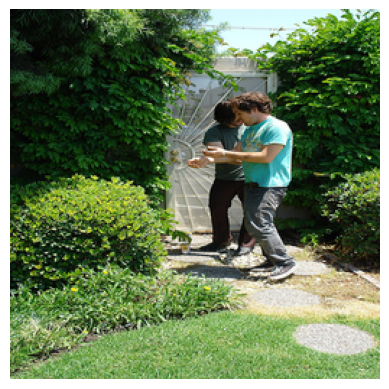

Shape of the tensor: torch.Size([256, 768])
first_dataset_image_patches: tensor([[0.0078, 0.0275, 0.0196,  ..., 0.0196, 0.0392, 0.0275],
        [0.0235, 0.0510, 0.0353,  ..., 0.0196, 0.0431, 0.0196],
        [0.0275, 0.0471, 0.0235,  ..., 0.0471, 0.0980, 0.0627],
        ...,
        [0.4980, 0.6941, 0.3373,  ..., 0.5333, 0.7176, 0.4667],
        [0.6196, 0.7412, 0.4549,  ..., 0.5216, 0.6902, 0.3961],
        [0.5608, 0.7176, 0.4392,  ..., 0.5373, 0.6510, 0.3843]])


In [45]:
def generate_patches(image):
    # Resize the image using PIL's Image.LANCZOS (high-quality downsampling filter)
    resized_image = image.resize(input_image_resize_shape, Image.LANCZOS)

    # Display the resized image using matplotlib
    plt.imshow(resized_image)
    plt.axis('off')  # Hide axes to focus on the image
    plt.show()

    # Convert the resized image to a numpy array
    image_np = np.array(resized_image)

    # Normalize pixel values to be between 0 and 1
    image_np = image_np.astype(np.float32) / 255.0

    # Calculate the number of blocks in each dimension
    blocks_x = image_np.shape[1] // sub_image_block_size
    blocks_y = image_np.shape[0] // sub_image_block_size

    # Prepare a list to hold the flattened blocks
    flattened_blocks = []

    # Split the image into blocks and flatten each
    for y in range(blocks_y):
        for x in range(blocks_x):
            block = image_np[y * sub_image_block_size:(y + 1) * sub_image_block_size, x * sub_image_block_size:(x + 1) * sub_image_block_size]
            flattened_blocks.append(block.flatten())

    # Convert the list of flattened blocks to a NumPy array
    flattened_blocks_np = np.array(flattened_blocks)

    # Convert the NumPy array to a PyTorch tensor of type float
    flattened_blocks_tensor = torch.tensor(flattened_blocks_np, dtype=torch.float32)

    # Print the shape of the tensor to verify
    print("Shape of the tensor:", flattened_blocks_tensor.shape)

    return flattened_blocks_tensor


first_dataset_image_patches = generate_patches(first_dataset_image)
print(f"first_dataset_image_patches: {first_dataset_image_patches}")

# Step X - Sentence piece setup

Generate the Corpus

In [46]:
# Specify the directory where you want to save the files
if not os.path.exists(sentencepiece_output_dir):
    os.makedirs(sentencepiece_output_dir)

# Save all texts to a single file in the specified directory, one story per line
sentencepiece_corpus_file_path = os.path.join(sentencepiece_output_dir, sentencepiece_corpus_filename)

# Initialize a list to store the data
captions = []

# Stream data and collect only the 'caption' column
# Save all texts to a single file, one story per line
with open(sentencepiece_corpus_file_path, 'w', encoding='utf-8') as f:       
    sample_count = 0
    for sample in dataset_stream:
        sample_count += 1
        for caption in sample['caption']:
            f.write(caption + '\n')
            captions.append(caption)
        if sample_count >= num_entries_for_sentence_piece_model:  # Stop after collecting 10 entries
            break

# Convert the list to a pandas DataFrame
df_captions = pd.DataFrame(captions, columns=['caption'])

# Display the DataFrame
print(len(df_captions))

60000


In [47]:
spm.SentencePieceTrainer.train(input=sentencepiece_corpus_file_path, model_prefix=sentencepiece_model_prefix, vocab_size=caption_vocabulary_size, character_coverage=0.9995, model_type='unigram')

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: ../sentencepiece_models/image_captions.txt
  input_format: 
  model_prefix: ../sentencepiece_models/image_captions_spm
  model_type: UNIGRAM
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: 

In [48]:
spm_model_path = f"{sentencepiece_model_prefix}.model"
sp = spm.SentencePieceProcessor(model_file=spm_model_path)

In [49]:
# Attempt the encodings

test_string = "hii there"

tokens = sp.encode(test_string, out_type=int)

print(tokens)
print(sp.decode(tokens))

[1477, 1640, 583]
hii there


In [50]:
with open('../datasets/image_captions/input.txt', 'r', encoding='utf-8') as f:
    caption_text = f.read()

print (f"Lenght of text: {len(caption_text)}")

caption_data = torch.tensor(sp.encode(caption_text), dtype=torch.long)
print(f"data.shape: {caption_data.shape}, data.dtype: {caption_data.dtype}")
print(caption_data[:1000])

caption_train_data, caption_val_data = split_data_train_validation(caption_data) 

Lenght of text: 3713418
data.shape: torch.Size([831076]), data.dtype: torch.int64
tensor([  21,   29,  396,   13, 1888,  139,  200,   22,    7,   76,  183,   33,
         366,   83,    6,    7,  418,    4,   21,   29,   14,  922,  797,   18,
          66,   88,   11,   92, 1534,    4,   21,   40,    6,   58,  311,   18,
          39,    6,    3,  418,    4,    5,   11,    6,    3,   31,   27,   39,
           6,    3,  903,    4,   21,  557,  538,  687, 3356, 2048,  141,    4,
         290,  279,   40,    6,  322,  294,   18, 1564,    3,  889, 2670, 2936,
           4,  852,  200,   46,   77,   57,  374,    8,    3,  306,   12,  465,
           4,   21,   40,  114,    8,    3,  443,   23,  322,  294,    4,  153,
          40,    8,  113,   12,    3,  448,  509,    4,   64,   42,   40,    8,
           3,   61, 4533,    4,    5,   50,    6,    3,  104,  143,   10,  207,
          57,    3,  407,   12,  497,    6,   34, 4916,  782,    4,    5,   55,
          37,    6,    3,  104,  143, 

# Sidestep - character based corpus

In [51]:
with open('../datasets/image_captions/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print (f"Lenght of text: {len(text)}")

# Generate tokens (on a character level)
chars = sorted(list(set(text)))
character_vocab_size = len(chars)

print(''.join(chars))
print(character_vocab_size)

Lenght of text: 3713418

 !"#$&'()+,-.0123456789:;?@ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
80


In [52]:
# Create mappings between characters and integer tokens
stoi = {ch:i for i, ch in enumerate(chars)}
itos = {i:ch for i, ch in enumerate(chars)}

encode_character = lambda s: [stoi[c] for c in s] # Convert a string to a list of integers
decode_character = lambda l: ''.join([itos[i] for i in l]) # Convert a list of integers to a string

print(encode_character("hii there"))
print(decode_character(encode_character("hii there")))

[61, 62, 62, 1, 73, 61, 58, 71, 58]
hii there


In [53]:
data = torch.tensor(encode_character(text), dtype=torch.long)
print(f"data.shape: {data.shape}, data.dtype: {data.dtype}")
print(data[:1000])

character_train_data, character_val_data = split_data_train_validation(data) 

data.shape: torch.Size([3713418]), data.dtype: torch.int64
tensor([47, 76, 68,  1, 78, 68, 74, 67, 60,  1, 60, 74, 78, 72,  1, 76, 62, 73,
        61,  1, 72, 61, 54, 60, 60, 78,  1, 61, 54, 62, 71,  1, 65, 68, 68, 64,
         1, 54, 73,  1, 73, 61, 58, 62, 71,  1, 61, 54, 67, 57, 72,  1, 76, 61,
        62, 65, 58,  1, 61, 54, 67, 60, 62, 67, 60,  1, 68, 74, 73,  1, 62, 67,
         1, 73, 61, 58,  1, 78, 54, 71, 57, 13,  0, 47, 76, 68,  1, 78, 68, 74,
        67, 60, 11,  1, 50, 61, 62, 73, 58,  1, 66, 54, 65, 58, 72,  1, 54, 71,
        58,  1, 68, 74, 73, 72, 62, 57, 58,  1, 67, 58, 54, 71,  1, 66, 54, 67,
        78,  1, 55, 74, 72, 61, 58, 72, 13,  0, 47, 76, 68,  1, 66, 58, 67,  1,
        62, 67,  1, 60, 71, 58, 58, 67,  1, 72, 61, 62, 71, 73, 72,  1, 54, 71,
        58,  1, 72, 73, 54, 67, 57, 62, 67, 60,  1, 62, 67,  1, 54,  1, 78, 54,
        71, 57, 13,  0, 28,  1, 66, 54, 67,  1, 62, 67,  1, 54,  1, 55, 65, 74,
        58,  1, 72, 61, 62, 71, 73,  1, 72, 73, 54, 67, 57, 6

# Encoding functions

In [54]:
def encode_token (token):
    if using_sentence_piece:
        return sp.encode(token, out_type=int)
    else:
        return encode_character(token)

def decode_token (token):
    if using_sentence_piece:
        return sp.decode(token)
    else:
        return decode_character(token)

In [55]:
if using_sentence_piece:
    train_data = caption_train_data
    val_data = caption_val_data
    vocab_size = caption_vocabulary_size
else:
    train_data = character_train_data
    val_data = character_val_data
    vocab_size = character_vocab_size

# Datasets and dataloaders

In [56]:
def get_batch(split, train_data, val_data):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss(train_data, val_data):
    out = {}
    bigram_lm.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, train_data, val_data)
            logits, loss = bigram_lm(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    bigram_lm.train()
    return out

# Models

## Shared models

In [57]:
# custom implementation for reference.
class LayerNorm1d:

    def __init__(self, dimensions, epsilon=1e-5):
        self.epsilon = epsilon
        self.gamma = torch.ones(dimensions)
        self.beta = torch.zeros(dimensions)

    def __call__(self, x):
        xmean = x.mean(1, keepdim=True) # batch mean
        xvar = x.var(1, keepdim=True) # batch variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.epsilon) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta # scale and shift
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

torch.manual_seed(1337)
module = BatchNorm1d(100)
x = torch.randn(32, 100)
x = module(x)
x.shape

x[:,0].mean(), x[:,0].std()

NameError: name 'BatchNorm1d' is not defined

In [65]:
class Head(nn.Module):
    """ One head self attention """
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(num_embedding_dimensions, head_size, bias=False)
        self.query = nn.Linear(num_embedding_dimensions, head_size, bias=False)
        self.value = nn.Linear(num_embedding_dimensions, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x) # (B, T, C)
        q = self.query(x) # (B, T, C)

        # compute attention scores ("affinities")
        weigths = q @ k.transpose(-2, -1) * C ** -0.5 # (B, T, C) @ (B, C, T) = (B, T, T)
        weigths = weigths.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        weigths = F.softmax(weigths, dim=-1) # (B, T, T)
        weigths = self.dropout(weigths)

        # Perform the weighted aggregation of the values
        v = self.value(x)
        out = weigths @ v # (B, T, T) @ (B, T, C) = (B, T, C)
        return out



In [66]:
# Multi-head attention model
class MultiHeadAttention(nn.Module):
    """ Multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.projection = nn.Linear(num_heads * head_size, num_embedding_dimensions)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        out = self.projection(out)
        out = self.dropout(out)
        return out

In [67]:
class FeedForward(nn.Module):
    """ A simple feed-forward network """

    def __init__(self, num_embeddings):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_embeddings, 4 * num_embeddings),
            nn.ReLU(),
            nn.Linear(4 * num_embeddings, num_embeddings),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [68]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, num_embeddings, num_heads) -> None:
        super().__init__()
        head_size = num_embeddings // num_heads
        self.self_attention = MultiHeadAttention(num_heads, head_size)
        self.feed_forward = FeedForward(num_embeddings)
        self.layer_norm_1 = nn.LayerNorm(num_embeddings)
        self.layer_norm_2 = nn.LayerNorm(num_embeddings)

    def forward(self, x):
        x = x + self.self_attention(self.layer_norm_1(x))
        x = x + self.feed_forward(self.layer_norm_2(x))
        return x



## Encoder transformer

In [69]:
class PatchToEmbedding(nn.Module):
    def __init__(self, pixel_tokens, num_embeddings):
        super(PatchToEmbedding, self).__init__()
        self.linear = nn.Linear(pixel_tokens, num_embeddings)

    def forward(self, x):
        return self.linear(x)
    

test_patch_to_embedding_model = PatchToEmbedding(flattned_patch_size, num_embedding_dimensions)
patch_to_embedding_output = test_patch_to_embedding_model(first_dataset_image_patches)
assert patch_to_embedding_output.shape == (num_patches, num_embedding_dimensions), f"Expected shape {(num_patches, num_embedding_dimensions)}, but got {patch_to_embedding_output.shape}"
print(patch_to_embedding_output.shape)


torch.Size([256, 32])


In [70]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_embeddings, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.num_embeddings = num_embeddings

        # Create a positional encoding matrix
        pe = torch.zeros(max_len, num_embeddings)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, num_embeddings, 2).float() * (-math.log(10000.0) / num_embeddings))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x: Tensor, shape [seq_length, num_embeddings]
        """
        # Check if the input sequence is too long
        if x.size(0) > self.pe.size(0):
            raise ValueError(f"Input sequence length ({x.size(0)}) is greater than the maximum length allowed ({self.pe.size(0)})")
        x = x + self.pe[:x.size(0), :]
        return x
    
test_positional_encoding = PositionalEncoding(num_embedding_dimensions)
test_positional_encoding_output = test_positional_encoding(patch_to_embedding_output)
assert test_positional_encoding_output.shape == (num_patches, num_embedding_dimensions), f"Expected shape {(num_patches, num_embedding_dimensions)}, but got {test_positional_encoding_output.shape}"
print(test_positional_encoding_output.shape)


torch.Size([256, 32])


In [71]:
class ImagePatchEncoder(nn.Module):
    def __init__(self, pixel_tokens, num_embeddings):
        super(ImagePatchEncoder, self).__init__()
        self.patch_to_embedding = PatchToEmbedding(pixel_tokens, num_embeddings)
        self.positional_encoding = PositionalEncoding(num_embeddings)

    def forward(self, x):
        x = self.patch_to_embedding(x)
        x = self.positional_encoding(x)
        return x

## Decoder transformer

In [72]:
class BigramLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, num_embedding_dimensions)
        self.position_embedding_table = nn.Embedding(block_size, num_embedding_dimensions)
        self.blocks = nn.Sequential(*[Block(num_embedding_dimensions, num_heads) for _ in range(num_layers)])
        self.layer_norm_final = nn.LayerNorm(num_embedding_dimensions)
        self.lm_head = nn.Linear(num_embedding_dimensions, vocab_size)
        
    def forward(self, index, targets = None):
        B, T = index.shape

        # index and targets are both (Batch, Time) tensor of integers        
        token_embeddings = self.token_embedding_table(index) # (Batch, Time, Channel)
        position_embeddings = self.position_embedding_table(torch.arange(T, device=device)) # (Time, Channel)
        x = token_embeddings + position_embeddings # (Batch, Time, Channel)
        x = self.blocks(x) # (Batch, Time, Channel)
        x = self.layer_norm_final(x) # (Batch, Time, Channel)
        logits = self.lm_head(x) # (B, T, vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, index, max_new_tokens):
        for _ in range(max_new_tokens):
            index_condition = index[:, -block_size:]
            # Get predictions
            logits, loss = self(index_condition)
            # Focus only on the last token (timestep)
            logits = logits[:, -1, :] # (Batch, Vocab)
            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)  # (Batch, Vocab)
            # Sample from the distribution
            index_next = torch.multinomial(probs, num_samples=1) # (Batch, 1)
            # Append sampled index to the running sequence
            index = torch.cat((index, index_next), dim=1) # (Batch, Time + 1)
        return index

bigram_lm = BigramLanguageModel()
m = bigram_lm.to(device)

# Training

In [73]:
optimizer = torch.optim.Adam(bigram_lm.parameters(), lr=learning_rate)

batch_size = 32
for iter in range(max_epochs):

    if iter % eval_interval == 0:
        losses = estimate_loss(train_data, val_data)
        print(f"Epoch: {iter}, Train loss: {losses['train']:.4f}, Val loss: {losses['val']:.4f}")

    # sampel a batch of data
    xb, yb = get_batch('train', train_data, val_data)

    # evaluate the loss
    token_embeddings, loss = bigram_lm(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

Epoch: 0, Train loss: 9.4187, Val loss: 9.4232
Epoch: 300, Train loss: 5.3445, Val loss: 5.4412
Epoch: 600, Train loss: 4.8969, Val loss: 4.9452
Epoch: 900, Train loss: 4.6721, Val loss: 4.7328
Epoch: 1200, Train loss: 4.4822, Val loss: 4.5994
Epoch: 1500, Train loss: 4.3966, Val loss: 4.5016
Epoch: 1800, Train loss: 4.2931, Val loss: 4.3843
Epoch: 2100, Train loss: 4.2404, Val loss: 4.3679
Epoch: 2400, Train loss: 4.1983, Val loss: 4.3002
Epoch: 2700, Train loss: 4.1235, Val loss: 4.2707
Epoch: 3000, Train loss: 4.1223, Val loss: 4.2223
Epoch: 3300, Train loss: 4.0840, Val loss: 4.2610
Epoch: 3600, Train loss: 4.0705, Val loss: 4.2093
Epoch: 3900, Train loss: 4.0015, Val loss: 4.1789
Epoch: 4200, Train loss: 3.9998, Val loss: 4.1383
Epoch: 4500, Train loss: 3.9792, Val loss: 4.1257
Epoch: 4800, Train loss: 3.9571, Val loss: 4.0988


In [74]:
context = torch.zeros((1, 1), dtype=torch.long).to(device)
print(decode_token(bigram_lm.generate(context, max_new_tokens=500)[0].tolist()))

 ⁇  fle player wearing red hats are standing together inside along with a soccer man in white colored top and a se in a blouse checking to flag with the ocean. A chefs pedals for the bus is surrounding a small rope perchd pole. A man wearing a blue shirt stands on a microphone. A group of roses-covered red colored midriff and his asian people at typesr A man is perch. A man with red hair doing a station doing the pavement. A woman in jeans with red outfit standing next to stream from tool the base. A young young man in a Santas a pumpkin, talking on a park. A climber is sleeping and another toddler, and a sheep while balancing staff at himself for shore. A group of red hair caught some sand. A man in black jeans is talking with a little boy are looking at another animal. A toddler in the ocean in the street at the camera. The pitbull for the camera. White girl makes a rodeo. Two people dressed in the park. A woman with a little watch at night while holding a young boy's stand on. A man

# The mathematical trick in self-attention

In [92]:
torch.manual_seed(1337) 
B,T,C  = 4, 8, 2 # Batch size, Time, Channels
x = torch.randn(B, T, C)
x.shape

# bow = bag of words
xbow = torch.zeros((B, T, C))
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1,:] # (t, C)
        xbow[b,t] = torch.mean(xprev, dim=0)


In [95]:
print(x[0])
print(xbow[0])

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])
tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])


In [104]:
# version 2
weigths = torch.tril(torch.ones(T, T))
weigths = weigths / weigths.sum(1, keepdim=True)
weigths
xbow2 = weigths @ x # (B, T, T) @ (B, T, C) -> (B, T, C)
torch.allclose(xbow, xbow2)

True

In [105]:
# version 3
tril = torch.tril(torch.ones(T, T))
weigths = torch.zeros((T,T))
weigths = weigths.masked_fill(tril == 0, float('-inf'))
weigths = F.softmax(weigths, dim=1)
xbow3 = weigths @ x
torch.allclose(xbow, xbow3)

True

In [139]:
# Version 4: seld-attention!
torch.manual_seed(1337)
B,T,C = 4, 8, 32 # Batch, Time, Channels
x = torch.randn(B, T, C)

# Let's see a single head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x) # (B, T, 16)
q = query(x) # (B, T, 16)

weigths = q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) -> (B, T, T)

tril = torch.tril(torch.ones(T, T))
# weigths = torch.zeros((T,T))
weigths = weigths.masked_fill(tril == 0, float('-inf'))
weigths = F.softmax(weigths, dim=-1)
out = weigths @ x

v = value(x)
out = weigths @ v
out.shape

torch.Size([4, 8, 16])

In [97]:
# Tril stands for triangle lower
torch.tril(torch.ones(3,3,))

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [152]:
torch.manual_seed(42)
#a  = torch.ones(3,3)
#a = torch.tril(torch.ones(3,3))
a = a / torch.sum(a, dim=1, keepdim=True)
b = torch.randint(0,10, (3,2)).float()
c = a @ b
print(f"a= {a}")
print('--')
print(f"b= {b}")
print('--')
print(f"c= {c}")
print('--')

a= tensor([[0.1667, 0.3333, 0.5000],
        [0.2667, 0.3333, 0.4000]])
--
b= tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c= tensor([[5.3333, 5.0000],
        [4.9333, 5.2000]])
--


In [153]:
# Examples of why we need scaled attention
k = torch.randn(B, T, head_size)
q = torch.randn(B, T, head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5 

In [154]:
print(k.var())
print(q.var())
print(wei.var())

tensor(0.9331)
tensor(0.8879)
tensor(0.8150)


In [155]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim= -1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [156]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim= -1)

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

# Exploration of Broadcasting in pytorch

Example without broadcasting:

In [126]:
# Creating a tensor of shape (2, 3) - imagine this as two sets of 3-channel embeddings
a = torch.tensor([[1, 2, 3], 
                  [4, 5, 6]])

# Creating another tensor of shape (2, 3) - similar structure as 'a'
b = torch.tensor([[1, 1, 1], 
                  [2, 2, 2]])

# Direct addition, no broadcasting needed as shapes are identical
result = a + b
print(result)


tensor([[2, 3, 4],
        [6, 7, 8]])


Example with broadcasting:

In [127]:
# Creating a tensor of shape (2, 3) - imagine this as two sets of 3-channel embeddings
a = torch.tensor([[1, 2, 3], 
                  [4, 5, 6]])

# Creating a tensor of shape (3,) - a single 3-channel embedding
b = torch.tensor([1, 1, 1])

# Addition with broadcasting: 'b' is automatically expanded to match the shape of 'a'
result = a + b
print(result)


tensor([[2, 3, 4],
        [5, 6, 7]])
